# COMPUTER VISION PIPELINE

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from IPython.display import Image

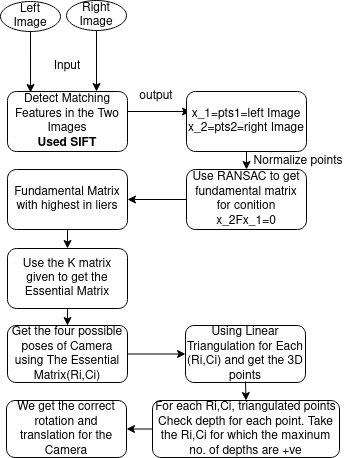

In [2]:
Image("pipeline_1.png")

1. So, using SIFT we first find the matching points in both left and right images.


In [3]:

# Reading Images
img_1 = cv2.imread('im0.png')
img_2 = cv2.imread('im1.png')
img1_1 = cv2.imread('im0.png')
img1_2 = cv2.imread('im1.png')


# Initialize SIFT object
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for each input image
kp1, des1 = sift.detectAndCompute(img_1,None)
kp2, des2 = sift.detectAndCompute(img_2,None)

#Initialize FLANN-based matcher
matcher = cv2.FlannBasedMatcher_create()

flann_params = dict(algorithm=1, trees=5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

# Perform matching between adjacent images
matches_12= matcher.knnMatch(des1,des2,k=2)
# Functions to find the best matches 
def best_matches(matches):
    best_match = []
    for best in matches:
        if (best[0].distance < 0.65*best[1].distance):
            best_match.append(best)
    matches = np.asarray(best_match)
    # matches = sorted(matches, key=lambda x: x[0].distance)
    matches=np.asarray(matches)
    return matches

# Find best mactches to compare only best matches
good_matches_1= best_matches(matches_12)


In [4]:
pts1 = np.float32([ kp1[m.queryIdx].pt for m in good_matches_1[:,0] ])
pts2 = np.float32([ kp2[m.trainIdx].pt for m in good_matches_1[:,0] ])



In [5]:
pts1_good=[]
pts2_good=[]
good_matches=[]
for i in range(len(pts1)):
    if(abs(pts1[i][1]-pts2[i][1])<5) and (abs(pts1[i][0]-pts2[i][0])<200):
        pts1_good.append(pts1[i])
        pts2_good.append(pts2[i])
        good_matches.append(good_matches_1[i])
    


        


In [6]:
pts1=np.asarray(pts1_good)
pts2=np.asarray(pts2_good)
good_matches=np.asarray(good_matches)
len(good_matches)

1281

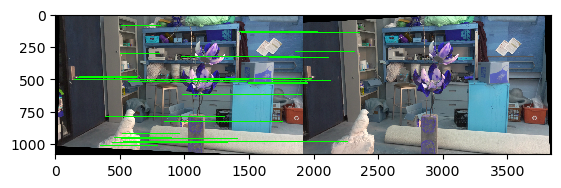

In [7]:
# Create a new image that will contain the drawn matches
height_1, width_1 = img_1.shape[:2]
height_2, width_2 = img_2.shape[:2]
# new_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
new_img=np.hstack([img_1,img_2])

# Iterate over each point pair in pts1 and pts2
for i in range(100):
    pt1 = tuple(map(int, pts1[i]))
    pt2 = tuple(map(int, pts2[i]))

    # For each pair, draw a line connecting the two points on the new image
    pt2 = (pt2[0] + width_1, pt2[1])
    cv2.line(new_img, pt1, pt2, (0, 255, 0), 1)

# Display the new image with the drawn matches
plt.imshow(new_img)
cv2.imwrite('Matches.jpg', new_img)
plt.show()


### Fundamental Matrix
   
We can obtain F from: $x′ TiFxi=0$ where i=1,2,....,m. This is known as epipolar constraint or correspondance condition (or Longuet-Higgins equation). Since, F is a 3×3 matrix, we can set up a homogenrous linear system with 9 unknowns:

$\begin{bmatrix} x'_i & y'_i & 1 \end{bmatrix}
\begin{bmatrix}f_{11} & f_{12} & f_{13} \\ f_{21} & f_{22} & f_{23} \\ f_{31} & f_{32} & f_{33} \end{bmatrix}
\begin{bmatrix} x_i \\ y_i \\ 1 \end{bmatrix} = 0$

$\begin{equation}x_i x'_i f_{11} + x_i y'_i f_{21} + x_i f_{31} + y_i x'_i f_{12} + y_i y'_i f_{22} + y_i f_{32} +  x'_i f_{13} + y'_i f_{23} + f_{33}=0\end{equation}$

We can simplify this as

$\begin{bmatrix} x_1 x'_1 & x_1 y'_1 & x_1 & y_1 x'_1 & y_1 y'_1 & y_1 &  x'_1 & y'_1 & 1 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_m x'_m & x_m y'_m & x_m & y_m x'_m & y_m y'_m & y_m &  x'_m & y'_m & 1 \end{bmatrix}\begin{bmatrix} f_{11} \\ f_{21} \\ f_{31} \\ f_{12} \\ f_{22} \\ f_{32} \\ f_{13} \\f_{23} \\ f_{33}\end{bmatrix} = 0$

Using atleast 8 correspondences the fundamental matrix F can be found out. Looking at the above equation we know it is of the type Ax=0 and using SVD we can solve the equation and get the F matrix.



In [8]:
def compute_fundamental_matrix(src_points,dst_points):
    # Create matrix A from source and destination points
    
    A = []
    for src_point, dst_point in zip(src_points, dst_points):
        x1, y1,z1 = src_point
        x, y,z = dst_point
        A.append([x1*x, x1*y, x1, y1*x, y1*y, y1, x, y, 1])

    A = np.array(A)
    # Compute SVD of A
    U, S, V = np.linalg.svd(A)

    fundamental_matrix = V[-1,:].reshape(3, 3)
    U, S, Vt = np.linalg.svd(fundamental_matrix)

    S[2] = 0

    fundamental_matrix= U @ np.diag(S) @ Vt

    return fundamental_matrix

### Normalization

The function below normalizes the points that we use for finding the fundamental matrix.

1. First we will find the centroid of this points

$\begin{equation}
    \boldsymbol{\bar{u}}=\frac{1}{n}\sum_{i=1}^{n}{u_i}
\end{equation}
\begin{equation}
    \boldsymbol{\bar{v}}=\frac{1}{n}\sum_{i=1}^{n}{v_i}
\end{equation}$

2. Next we will recenter the points based on the centroid

$\begin{equation}
    \boldsymbol{\tilde{u}} = \boldsymbol{u} - \boldsymbol{\bar{u}}
\end{equation}
\begin{equation}
    \boldsymbol{\tilde{v}} = \boldsymbol{v} - \boldsymbol{\bar{v}}
\end{equation}$

3. Next step is to define a scaling factor $s$ and $s'$ for finding the average distances of the centered points from the origin for both left and right images(Note all operations above too are being done for both left and right images):

$\begin{equation}
    \begin{aligned}
    \boldsymbol{s} &= \frac{\sqrt{2}}{\left(\frac{1}{n}\sum_{i=1}^{n}\left({\tilde{u}_i^{2}+\tilde{v}_i^{2}}\right)\right)^{1/2}}\\
    \\
    \boldsymbol{s'} &= \frac{\sqrt{2}}{\left(\frac{1}{n}\sum_{i=1}^{n}\left({\tilde{u'}_{i}^{2}+\tilde{v'}_i^{2}}\right)\right)^{1/2}}
    \end{aligned}
\end{equation}$

4. Here $\tilde{u'}$ and $\tilde{v'}$ are the centered points of image 2.

5. Next step is to calculate Ta and Tb from the above distances which will act as transformation matrices which will be later 
used to normalize and unnormalize the feature point coordinates and find the normalized and unnormalized Fundamental matrices.

$\begin{equation}
    \begin{aligned}
    T_{a} &= \begin{bmatrix}
    s & 0 & 0 \\
    0 & s & 0 \\
    0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    1 & 0 & -\boldsymbol{\bar{u}} \\
    0 & 1 & -\boldsymbol{\bar{v}} \\
    0 & 0 & 1
    \end{bmatrix} \\
    T_{b} &= \begin{bmatrix}
    s' & 0 & 0 \\
    0 & s' & 0 \\
    0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    1 & 0 & -\boldsymbol{\bar{u}'} \\
    0 & 1 & -\boldsymbol{\bar{v}'} \\
    0 & 0 & 1
    \end{bmatrix}
    \end{aligned}
\end{equation}$

6. The normalized corrospondence points can be calculated from below equations:

$\begin{equation}
\begin{aligned}
\boldsymbol{\hat{x_i}} &= T_a\boldsymbol{x} \\
\boldsymbol{\hat{x'}_i} &= T_b\boldsymbol{x'}
\end{aligned}
\end{equation}$

where $x_{i}$ or $x'_{i}$ is denoted by 
$\begin{bmatrix}                                                                    
    u \\                                                                                                                    
    v \\                                                                                                                    
\end{bmatrix}$ or 
$\begin{bmatrix}                                                                                          
    u' \\                                                                                                                   
    v' \\                                                                                                                   
\end{bmatrix}$ which are image feature point coordinates supplied by sift descriptors.

7. We will use this normalized points to solve for $\boldsymbol{F}$ fundamental matrix, using RANSAC. Once we have the fundame
ntal matrix from the normalized coordinates we will use the transformations $T_a$ and $T_b$ to find the unnormalized version of fundamental matrix as shown below

$\begin{equation}
    F_{orig} = \boldsymbol{T_{b}}^{T}F_{norm}\boldsymbol{T_{a}}
\end{equation}$

All this math is from the following source
https://cmsc733.github.io/2022/proj/p3/#tri


In [9]:
def normalize(points):
    
    centroid = np.mean(points, axis=0)
    
    centered_points = points - centroid
    
    # Scale the points so that the average distance from the origin is equal to sqrt(2).
    s = (2 / np.mean(np.sum(centered_points ** 2, axis=1))) ** 0.5
    
    # Combine the translation and scaling transformations into a single 3x3 matrix.
    T_scale = np.diag([s, s, 1])
    T_trans = np.array([[1, 0, -centroid[0]], [0, 1, -centroid[1]], [0, 0, 1]])
    T = T_scale.dot(T_trans)
    
    # Apply the transformation to the homogeneous coordinates of the points.
    homogeneous_points = np.column_stack((points, np.ones(points.shape[0])))
    normalized_points = (T.dot(homogeneous_points.T)).T
    
    return normalized_points, T

https://cmsc733.github.io/2022/proj/p3/#tri

Perfroming RANSAC to get fundamental matrix using the above source

In [10]:
def estimate_fundamental_matrix(pts1, pts2, threshold=0.004, sample_size=8, max_iterations=2000):
    # Normalize input points
    pts1_norm, T1 = normalize(pts1)
    pts2_norm, T2 = normalize(pts2)

    # Initialize variables
    best_F = None
    best_n_inliers = 0
    inliers = []

    # Iterate over RANSAC samples
    for i in range(max_iterations):
        # Select a random sample of corresponding points
        sample_indices = np.random.choice(pts1.shape[0], sample_size, replace=False)
        src_pts = pts1_norm[sample_indices,:]
        dst_pts = pts2_norm[sample_indices,:]

        # Compute fundamental matrix from sample
        F = compute_fundamental_matrix(src_pts, dst_pts)

        # Compute epipolar line constraint for all points
        no_of_inliers = 0
        temp_inliers = []
        for j in range(pts1_norm.shape[0]):
            L_r = np.dot(F,pts2_norm[j])
            D_lr = np.abs((L_r[0]*pts1_norm[j][0]+L_r[1]*pts1_norm[j][1]+L_r[2])/np.sqrt((L_r[0]**2+L_r[1]**2)))

            L_l = np.dot(pts1_norm[j],F)
            D_rl = np.abs((L_l[0]*pts2_norm[j][0]+L_l[1]*pts2_norm[j][1]+L_l[2])/np.sqrt((L_l[0]**2+L_l[1]**2)))

            if(D_lr+D_rl)<=threshold:
                no_of_inliers += 1
                temp_inliers.append([pts1[j],pts2[j]])

        # Update best solution if necessary
        if no_of_inliers > best_n_inliers:
            best_n_inliers = no_of_inliers
            best_F = F
            print(best_n_inliers)
            inliers = temp_inliers
            

        # Early termination if convergence is reached
        if no_of_inliers == pts1_norm.shape[0]:
            break

    # Denormalize fundamental matrix
    F_denorm = T2.T @ best_F @ T1




    return F_denorm,inliers


In [11]:
F,inlier=estimate_fundamental_matrix(pts1,pts2)

226
678
716
804
899
930
935
1004
1019
1095
1125
1133


In [12]:
F_final=F/F[2,2]
print("The Estimated Fundamental Matrix is=")
print(F_final)

The Estimated Fundamental Matrix is=
[[ 4.76765033e-11 -4.20293033e-06  2.82122399e-03]
 [ 3.71890789e-06  1.61862931e-08  3.37206649e-01]
 [-2.48998466e-03 -3.38369521e-01  1.00000000e+00]]


### DRAWING EPIPOLAR LINES

In [13]:
pts1_denorm = np.zeros((len(inlier), 2))
pts2_denorm = np.zeros((len(inlier), 2))

for k in range(len(inlier)):
    pts1_denorm[k] = inlier[k][0]
    pts2_denorm[k] = inlier[k][1]

pts1_denorm=np.uint(pts1_denorm)
pts2_denorm=np.uint(pts2_denorm)


In [14]:
random_indices = np.random.choice(pts2_denorm.shape[0], size=10, replace=False)
pts1_check=pts1_denorm[random_indices]
pts2_check=pts2_denorm[random_indices]


In [15]:
n=pts1_check.shape[0]
ones = np.ones((n, 1))

# concatenate the two arrays along axis 1 to create an n*3 array
pts1_check = np.concatenate((pts1_check, ones), axis=1)
pts2_check = np.concatenate((pts2_check, ones), axis=1)

In [16]:
def drawlines(img1,img2,lines,pts1,pts2):
    
    r,c,w = img1.shape

    for r,pt1,pt2 in zip(lines,pts1,pts2):
        colorofline = (255,0,0)
        colorofpoint= (0,255,0)
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), colorofline,3)
        pc1 = np.uint(pt1)
        pc2 = np.uint(pt2)
        img1 = cv2.circle(img1,(pc1[0],pc1[1]),5,colorofpoint,-1)
        img2 = cv2.circle(img2,(pc2[0],pc2[1]),5,colorofpoint,-1)
    return img1,img2

Epipolar lines before rectification


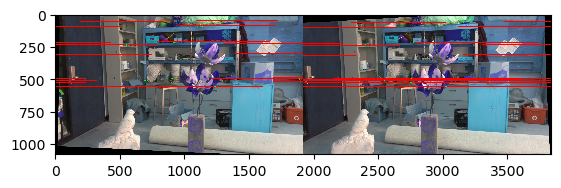

In [17]:
left_epipolar_line = []
for i in range(len(pts2_check)):
    left_epipolar_line.append(np.dot(F,pts2_check[i].T).T)
right_epipolar_line = []
for i in range(len(pts1_check)):
    right_epipolar_line.append(np.dot(pts1_check[i],F))
print("Epipolar lines before rectification")
img1, img__1_ = drawlines(img_1,img_2,left_epipolar_line,pts1_check,pts2_check)
img2, img__2_ = drawlines(img_2,img_1,right_epipolar_line,pts2_check,pts1_check)
# plt.subplot(121),plt.imshow(img1,interpolation='bicubic')
# plt.subplot(122),plt.imshow(img2,interpolation='bicubic')
# plt.show()
img = np.concatenate((img1,img2), axis =1)
plt.imshow(img)
cv2.imwrite('epi_lines_before.jpg', img)
plt.show()

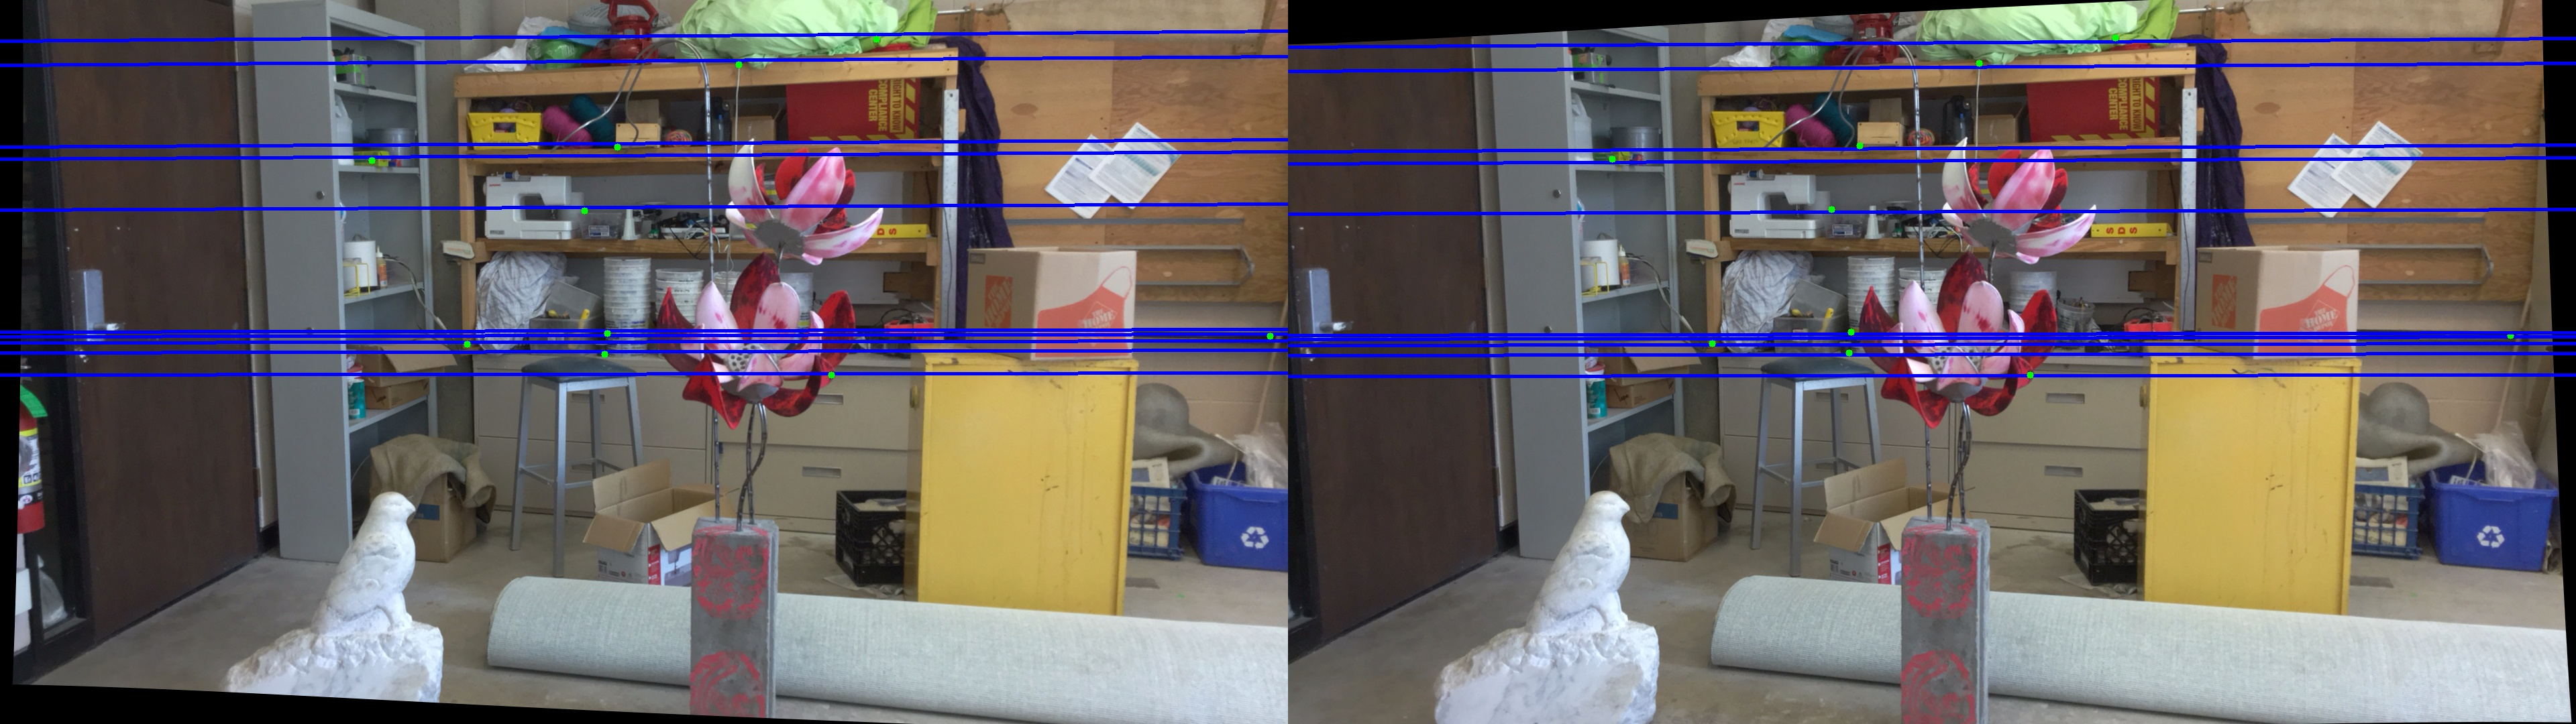

In [18]:
Image("epi_lines_before.jpg")

In [19]:
def Posible_CameraPoses(E_matrix):
    R_possible = []
    C_possible = []
    U,_,V = np.linalg.svd(E_matrix)
    
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    
    C1 = U[:,-1]
    R1 = np.dot(U,np.dot(W,V))
    if np.linalg.det(R1) == -1:
        R1 = -R1
        C1 = -C1
    R_possible.append(R1)
    C_possible.append(C1)
        
    C2 = U[:,-1]
    R2 = np.dot(U,np.dot(W.T,V))
    if np.linalg.det(R2) == -1:
        R2 = -R2
        C2 = -C2
    R_possible.append(R2)
    C_possible.append(C2)
        
    C3 = -U[:,-1]
    R3 = np.dot(U,np.dot(W,V))
    if np.linalg.det(R3) == -1:
        R3 = -R3
        C3 = -C3
    R_possible.append(R3)
    C_possible.append(C3)
        
    C4 = -U[:,-1]
    R4 = np.dot(U,np.dot(W.T,V))
    if np.linalg.det(R4) == -1:
        R4 = -R4
        C4 = -C4
    R_possible.append(R4)
    C_possible.append(C4)
        
    return R_possible, C_possible

In [20]:
cam0 = np.array([[1733.74, 0, 792.27], [0, 1733.74, 541.89], [0, 0, 1]])
E=cam0.T@F@cam0
U,S,V = np.linalg.svd(E)
S = np.diag(S)
S[1,1] = 1
S[0,0] = 1
S[2,2] = 0
E = np.dot(np.dot(U,S),V)
R_possible, C_possible = Posible_CameraPoses(E)
print("EStimated Essential Matrix")
print(E)

EStimated Essential Matrix
[[-2.47281381e-07  2.13203057e-02 -1.59119517e-03]
 [-1.89515932e-02 -4.07852324e-04 -9.99819067e-01]
 [ 1.39511404e-03  9.99771629e-01 -4.00529220e-04]]


### Correct Camera Pose
1. Let $\mathbf{R}_i$ be a possible camera rotation matrix, $\mathbf{C}_i$ be the corresponding camera center vector, and $\mathbf{x}_j$ be a triangulated 3D point. We want to find the camera pose $(\mathbf{R}, \mathbf{C})$ that maximizes the number of 3D points with positive depth:

$({R}, \mathbf{C}) = \operatorname{argmax}_{i} \sum_{j} [\mathbf{R}_i (\mathbf{x}_j - \mathbf{C}_i)]_3 > 0$

In [21]:
def correct_camerapose(R_possible, C_possible, triangulated_points_set):
    correct_index = 0
    max_positive_z = 0
   
    for i in range(len(R_possible)):
        positive_depths=  0
        R = R_possible[i]
        C = C_possible[i].reshape(3,1)
        r3 = R[2].T
        points = triangulated_points_set[i]
       
        for point in points:
            point = point.reshape(3, 1)
            if r3 @ (point - C) > 0 and point[2] > 0:
                positive_depths += 1
               
        if positive_depths > max_positive_z:
            correct_index = i
            max_positive_z = positive_depths

    R, C = R_possible[correct_index], C_possible[correct_index]

    return R, C

### Triangulation

1. Initialize the camera matrices for both views as $P = K_1 [I|0]$ and $P' = K_2 [R|t]$ where $K_1$ and $K_2$ are the intrinsic matrices of the cameras, and $R$ and $t$ are the rotation and translation matrices for the second camera with respect to the first camera.
2. Loop over the corresponding image points, $(u_1, v_1)$ and $(u_2, v_2)$, in the left and right images, respectively.
3. Compute the homogeneous image points as $\textbf{x} = [u_1, v_1, 1]^T$ and $\textbf{x}' = [u_2, v_2, 1]^T$.
4. Form the matrix $A$ as:  

$A = \begin{bmatrix}
y_1 P_3^\top - P_2^\top \\
P_1^\top - x_1 P_3^\top \\
y_2 P_3'^\top - P_2'^\top \\
P_1'^\top - x_2 P_3'^\top \\
\end{bmatrix}$
5. Compute the Singular Value Decomposition (SVD) of matrix $A$ as $A = U \Sigma V^T$.
6. The 3D point $\textbf{X}$ can be computed as the last column of the matrix $V$, normalized by its last element.
7. Append the resulting 3D point to the list of triangulated points.
   

In [22]:
def Trinagulated_Points(R_possible, C_possible, pts1_left, pts2_right, K1, K2):
    
    R1, R2 = np.identity(3), R_possible
    C1, C2 = np.zeros((3, 1)),  C_possible.reshape(3,1)
    
    
    P = K1@np.hstack((R1,-R1@C1))
    
    P_prime = K2@np.hstack((R2,-R2@C2))
    
    p1, p2, p3 = P
    p1_, p2_, p3_ = P_prime
    
    triangulated_points =[]
    
    for pt_left, pt_right in zip(pts1_left, pts2_right):
        x, y = pt_left
        x_, y_ = pt_right
        A = np.vstack((y * p3.T - p2.T, p1.T - x * p3.T, y_ * p3_.T - p2_.T, p1_.T-x_ * p3_.T ))
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X / X[-1]
        triangulated_points.append(X[:3])
        


    return triangulated_points

In [23]:
K1,K2=cam0,cam0
trinagulated_points_set=[]
for i in range(len(R_possible)):
    trinagulated_points_set.append(Trinagulated_Points(R_possible[i], C_possible[i], pts1, pts2, K1, K2))


R, C = correct_camerapose(R_possible, C_possible, trinagulated_points_set)
print("Rotation for Camera=")
print(R)
print("Transaltion of Camera=")
print(C)

Rotation for Camera=
[[-9.99184627e-01  2.99336481e-03  4.02631517e-02]
 [ 2.97708227e-03  9.99995461e-01 -4.64354942e-04]
 [ 4.02643589e-02  3.44109604e-04  9.99189003e-01]]
Transaltion of Camera=
[ 0.99977143 -0.00158258 -0.02132095]


### RECTIFICIATION

In [24]:
height_1, width_1,_ = img_1.shape
height_2, width_2,_ = img_2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated( np.float32(pts1_denorm), np.float32(pts2_denorm), F, imgSize=(width_1, height_1))
print("Homography for left Image")
print(H1)
print("Homography for Right Image")
print(H2)

Homography for left Image
[[ 2.03185719e-03 -6.33390929e-05 -1.52864497e-01]
 [ 1.46664483e-05  2.01683956e-03 -2.18304003e-02]
 [ 2.19054200e-08  5.56602076e-11  1.98626919e-03]]
Homography for Right Image
[[ 1.01178283e+00 -1.62176732e-03 -1.04357589e+01]
 [ 8.23144120e-03  9.99988091e-01 -7.89575247e+00]
 [ 1.22751156e-05 -1.96755477e-08  9.88226514e-01]]


In [25]:
image_left_rectified_1 = cv2.warpPerspective(img_1, H1, (width_1, height_1))
image_right_rectified_1 = cv2.warpPerspective(img_2, H2, (width_2, height_2))

Epipolar lines after rectification


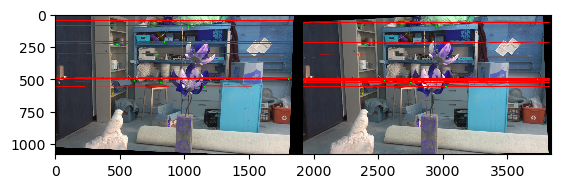

In [26]:
img = np.concatenate((image_left_rectified_1,image_right_rectified_1), axis =1)
print("Epipolar lines after rectification")
plt.imshow(img)
cv2.imwrite('perspective_epi_lines.jpg', img)
plt.show()


The epipolar lines seem to be horizontal after the perspective transfromation

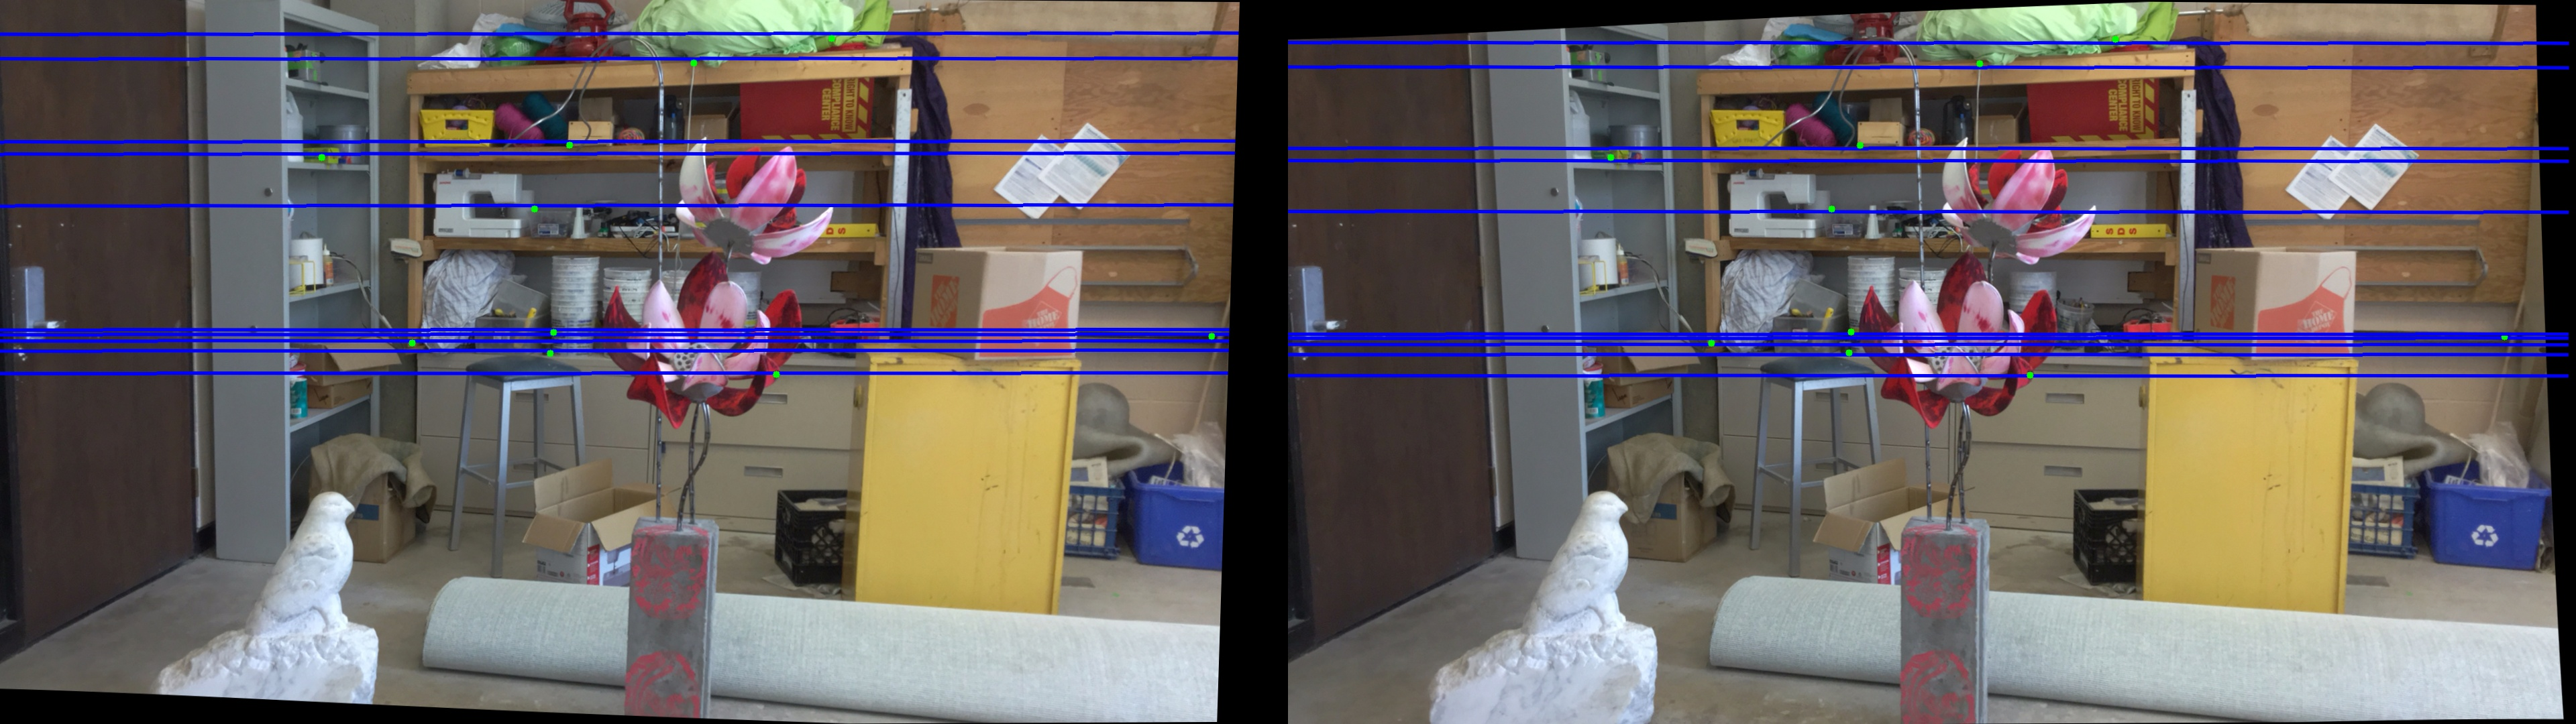

In [27]:
Image("perspective_epi_lines.jpg")

In [28]:
image_left_rectified = cv2.warpPerspective(img1_1, H1, (width_1, height_1))
image_right_rectified = cv2.warpPerspective(img1_2, H2, (width_2, height_2))

In [29]:
image_left_rect_gray = cv2.cvtColor(image_left_rectified , cv2.COLOR_BGR2GRAY)
image_right_rect_gray = cv2.cvtColor(image_right_rectified , cv2.COLOR_BGR2GRAY)

### CORRESPONDANCE

#### DISPARITY CALCULATION

The key mathematical operation is the calculation of the SSD between two image patches. The SSD is a measure of the dissimilarity between two patches, and is defined as the sum of the squared differences between corresponding pixels in the two patches. By comparing the SSD between E1 and E2 for different values of k, the function is able to find the best match between the patches, and use the corresponding horizontal displacement to compute the disparity map. The normalization step simply scales the disparity values to a more convenient range, while the conversion to 8-bit integers makes the resulting disparity map easier to visualize and store

In [30]:
def Disparity_Calculation(img1, img2):

    disparity = np.zeros((img2.shape[0], img2.shape[1]), dtype=np.float64)
    
    for i in range(5,img2.shape[1]-5):
        for j in range(5, img2.shape[0]-5):
            
            E1 = img2[j-5:j+5,i-5:i+5]
            
            max_SSD = np.inf
            corrp_index = 0
            for k in range(i-100, i+100, 3):
                if (k-5) < 0 or (k+5) > img1.shape[1]-1:
                    continue
                
                E2 = img1[j-5:j+5,k-5:k+5]
                
                diff = E1 - E2
                diff = np.array(diff)
                square_element = np.square(diff)
                SSD = square_element.sum()
                if SSD < max_SSD:
                    max_SSD = SSD
                    corrp_index = k      
            disparity[j][i] = i - corrp_index
            
    disparity = disparity + np.abs(np.min(disparity)) + 1
    disparity = (disparity/np.max(disparity))*255
    disparity = disparity.astype(np.uint8)
    return disparity

In [31]:
disparity = Disparity_Calculation(image_left_rect_gray, image_right_rect_gray)
disparity_heat = cv2.applyColorMap(disparity, cv2.COLORMAP_JET)

In [32]:
cv2.imwrite('Disparity.png', disparity)
cv2.imwrite('Disparity_Heat.png', disparity_heat)

True

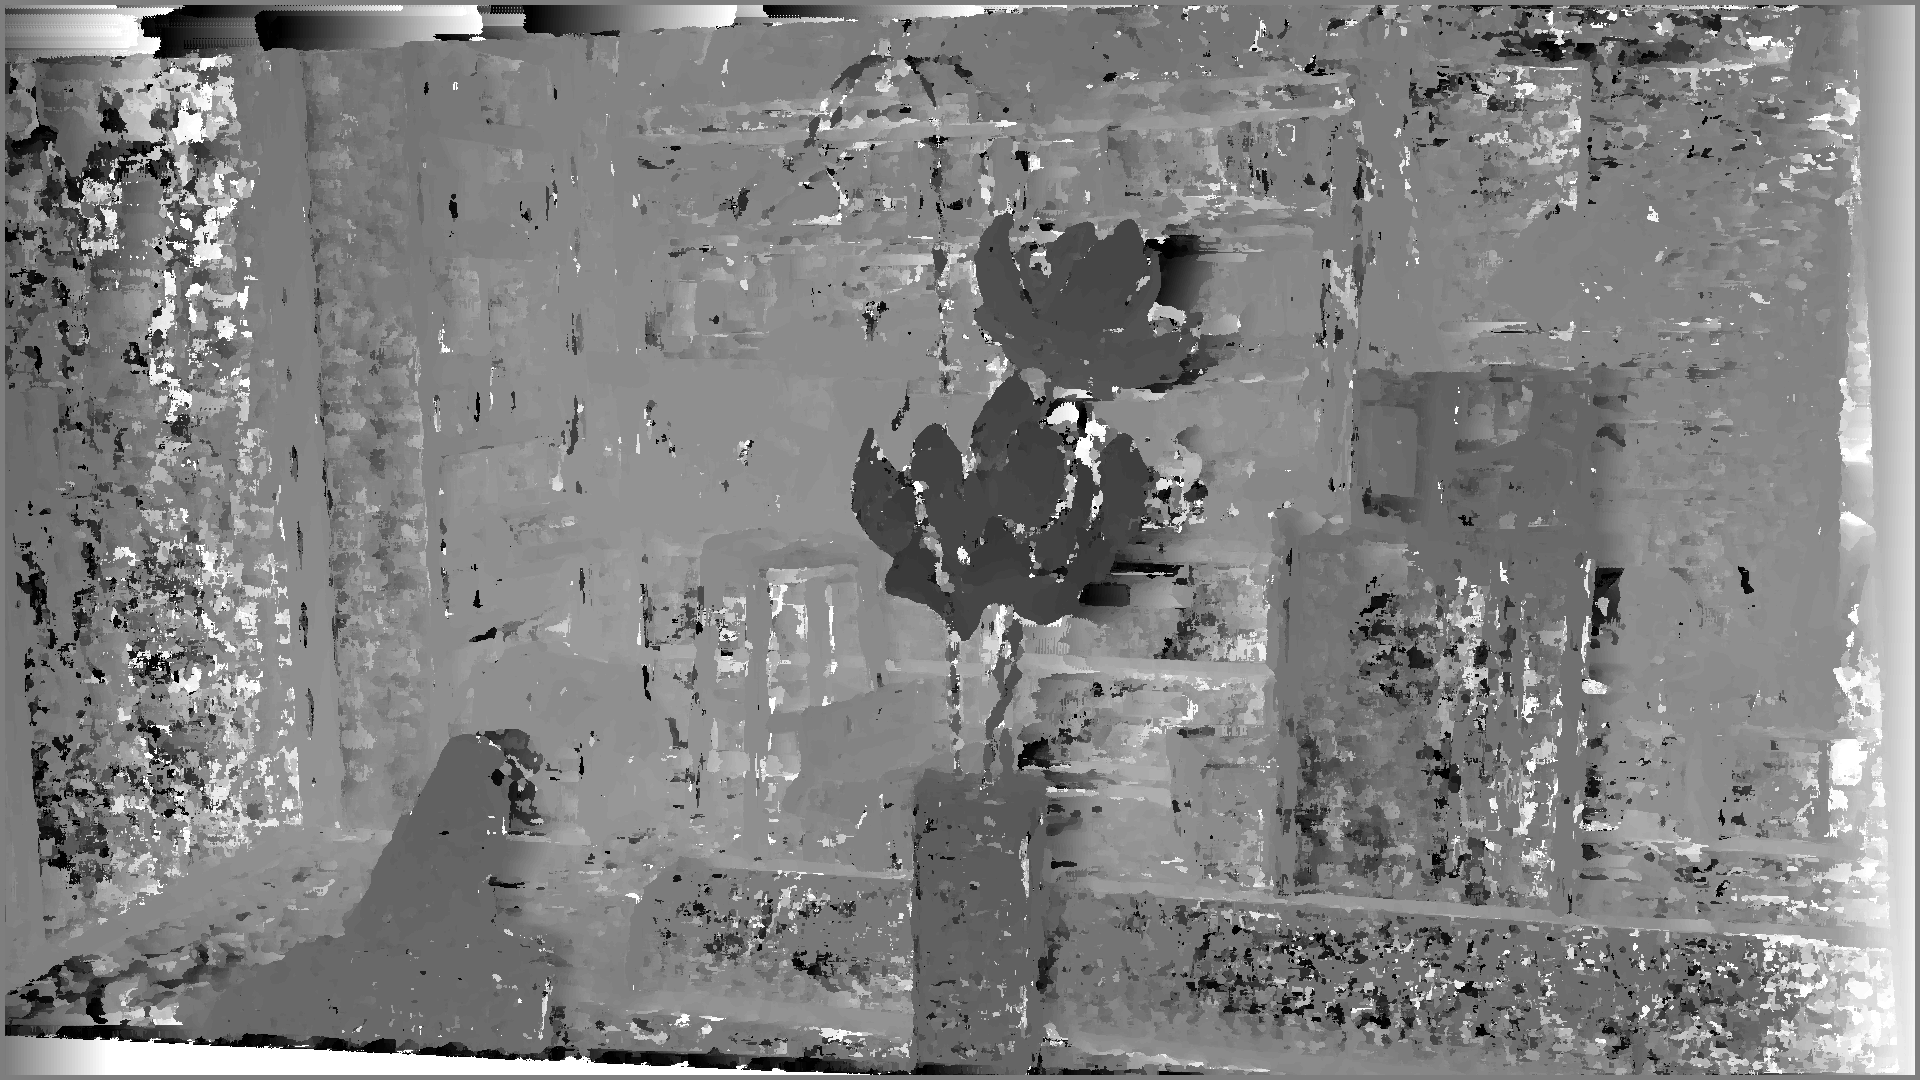

In [33]:
Image("Disparity.png")


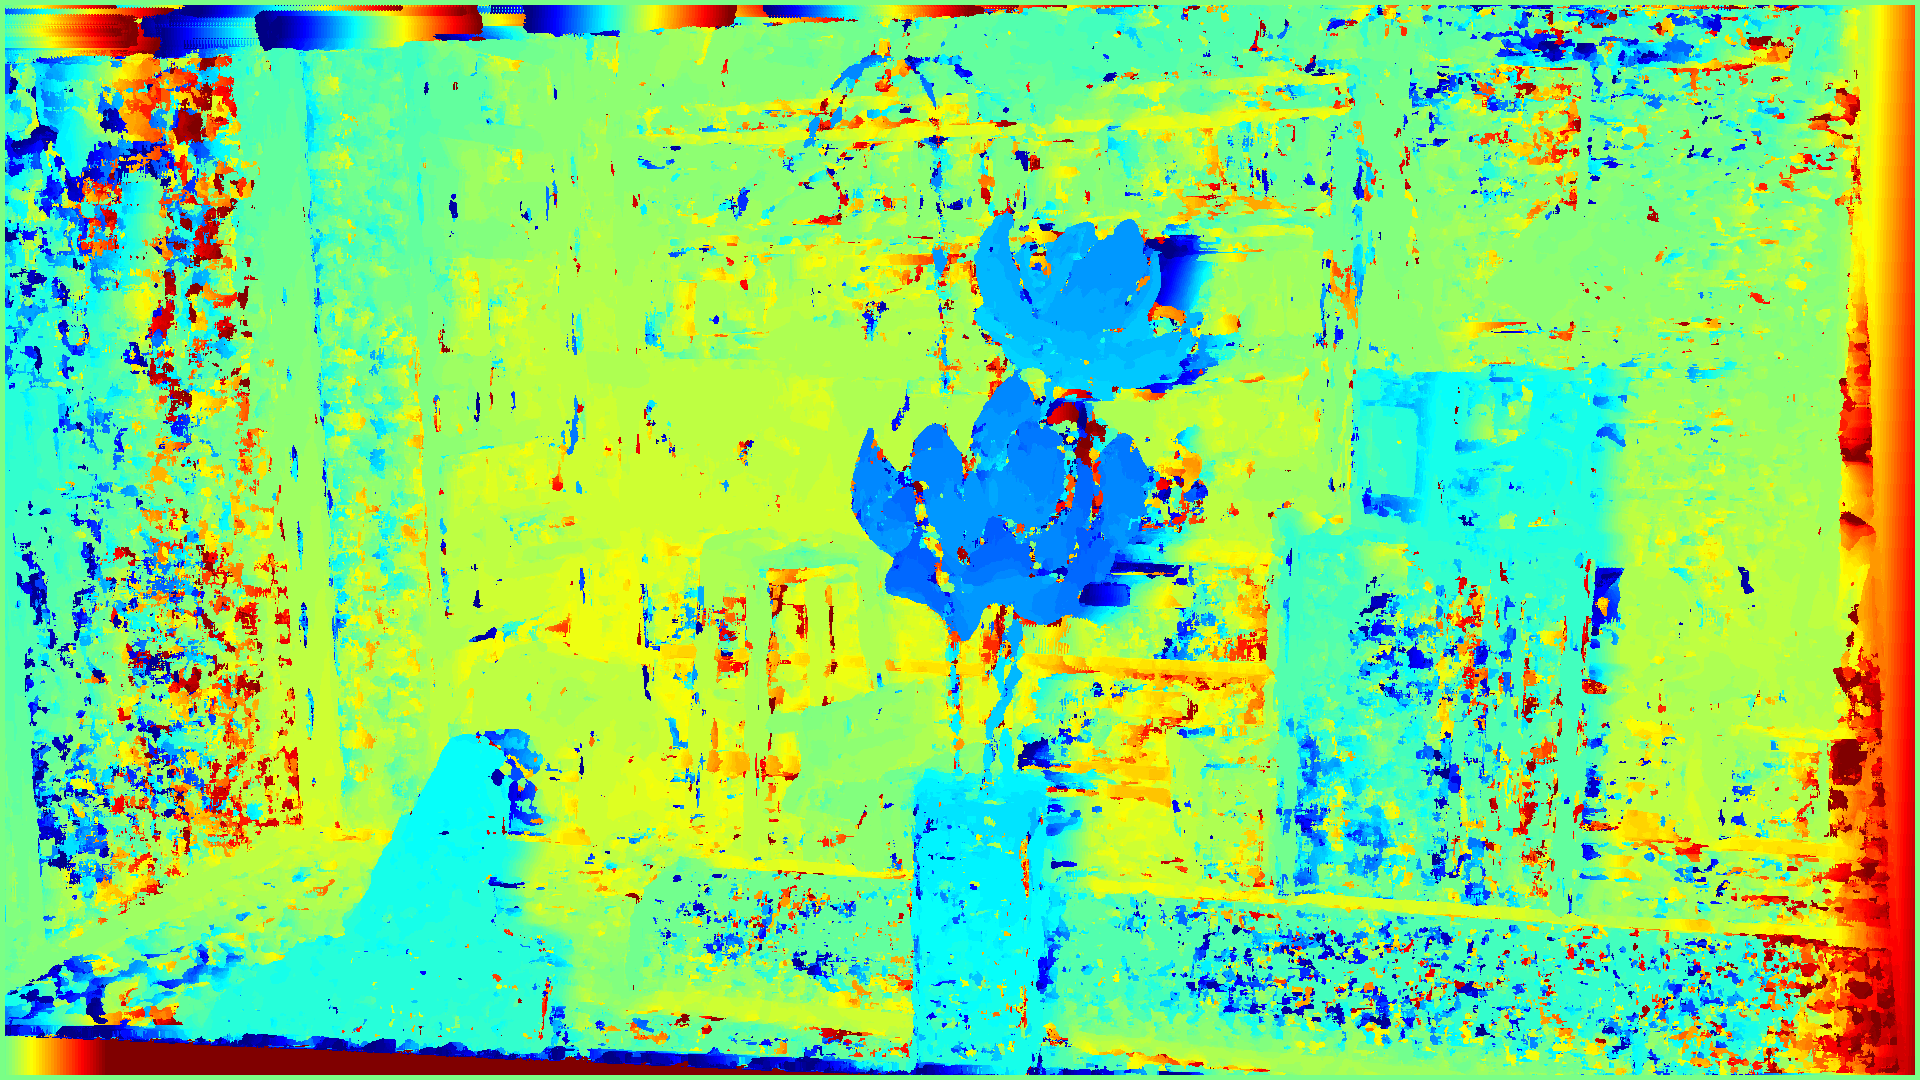

In [34]:
Image("Disparity_Heat.png")

#### COMPUTING DEPTH OF IMAGE

In [35]:
def computeDepthMap(img, b, f_x):
    
    img = img.astype(np.float64)
    depth = (b * f_x)/img
    depth[depth > 5000] = 5000
    depth = (depth/np.max(depth))*255
    depth = depth.astype(np.uint8)
    
    return depth 

In [36]:
b = 536.62
f_x = 1733.74
depth = computeDepthMap(disparity,b, f_x )
depth_heat = cv2.applyColorMap(depth, cv2.COLORMAP_JET)
cv2.imwrite('Depth.png', depth)
cv2.imwrite('Depth_Heat.png', depth_heat)

True

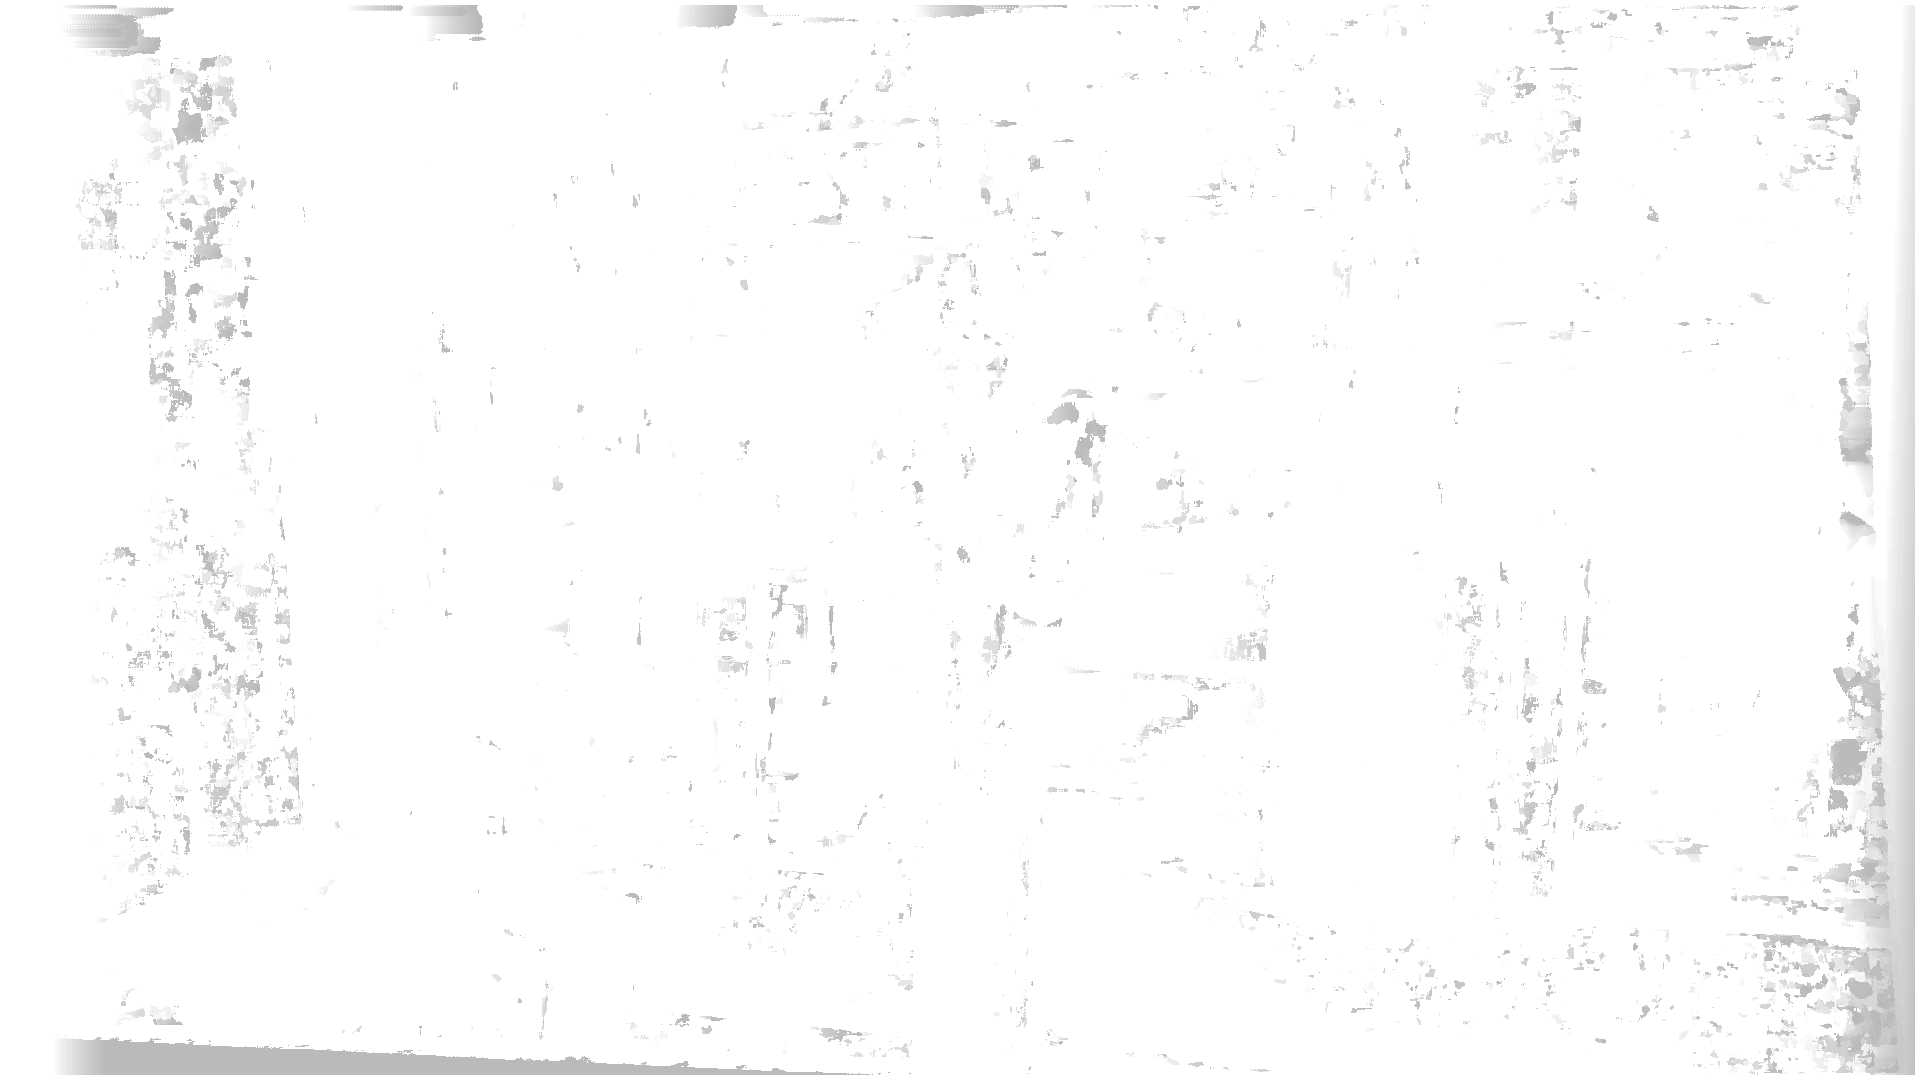

In [37]:
Image("Depth.png")


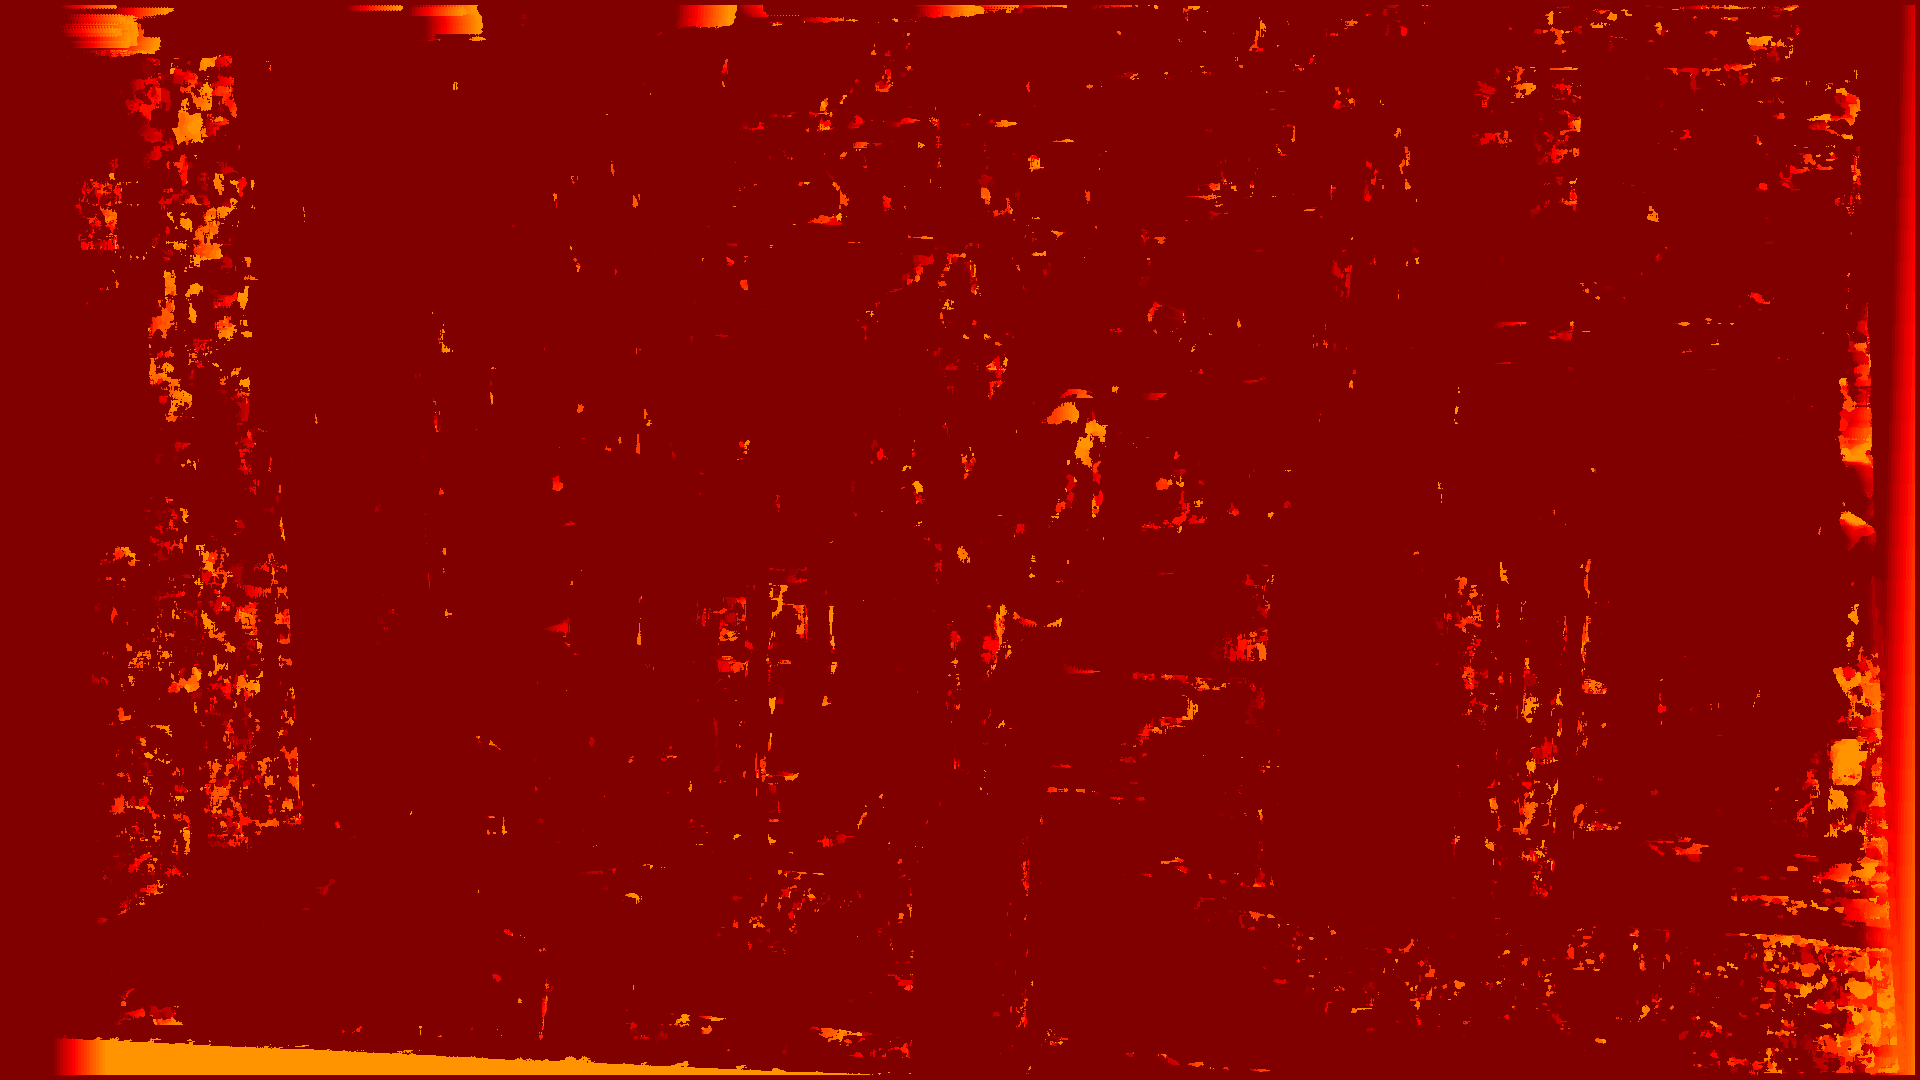

In [38]:
Image("Depth_Heat.png")

In [39]:
img1_final = np.hstack([disparity, depth])
img2_final = np.hstack([disparity_heat, depth_heat])
cv2.imwrite('final.png', img1_final)
cv2.imwrite('final_heat.png', img2_final)

True

Following this the same steps are followed for the other images 